<a id="toc"></a>
# Antares beamline simulation with PyOptiX

***

Contents :
1. [Optical elements declaration](#def_opt)
1. [Definition of optical parameters](#def_param)
1. [Alignment scripts](#alignement)
1. [Simulation execution](#exec)
1. [Calculations](#calcu)
1. [Monochromator resolution](#monores)
1. [Recalculation of the M1B mirror parameters](#M1Bis)


In [ ]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'CC BY-NC-SA 4.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '03/MAR/2025'
__changed__ = '03/MAR/2025'


from copy import copy
from itertools import product

import barc4xoc.beams as bm
import numpy as np
import pyoptix
import pyoptix.classes as opx
from barc4plots.barc4plots import PlotManager
from scipy.constants import c, degree, eV, h, milli, nano

hc = h*c/eV

In [ ]:
open_slit = True

pyoptix.set_aperture_active(np.logical_not(open_slit))
pyoptix.output_notebook()

In [ ]:
beamline = opx.Beamline(name="Antares - current")

# ------------------
# source
# ------------------

# UPST - upstream the centre of the straight section
# DWST - downstream the centre of the straight section

undulator_U256 = opx.UndulatorSource(name="U256")   # 10-280 eV - 894.5mm DWST
undulator_U60 = opx.UndulatorSource(name="U60")     # 70-1000 eV - 1830mm UPST
undulator_SII = opx.UndulatorSource(name="SII")     # HU64 - 70-1000 eV 276mm UPST with 
                                                    # SOLEIL-II magnetic lattice

# ------------------
# optical elements
# ------------------
pupil = opx.PlaneFilm(name="pupil")

# M1
m1a = opx.PlaneMirror(name="M1A")
m1b = opx.ToroidalMirror(name="M1B") # toroidal mirror
m1c = opx.ToroidalMirror(name="M1C") # toroidal mirror
# m1b = opx.SphericalMirror(name="M1B") # toroidal mirror
# m1c = opx.SphericalMirror(name="M1C") # toroidal mirror
# monochromator
grating_600 = opx.PlaneHoloGrating(name="grating_600")
grating_1300 = opx.PlaneHoloGrating(name="grating_1300")
grating_1600 = opx.PlaneHoloGrating(name="grating_1600")

m2 = opx.PlaneMirror(name="M2")

mono_hor_foc_slit = opx.PlaneFilm(name="mono_hfs")
mono_exit_slit = opx.PlaneFilm(name="mono_out")

# branch Wolter
m3 = opx.SphericalMirror(name="M3")
m4 = opx.ToroidalMirror(name="M4")
image_wolter = opx.PlaneFilm(name="wolter")


# branch ZP
m3z = opx.SphericalMirror(name="M3z")
m4z = opx.ToroidalMirror(name="M4z")
source_ZP = opx.PlaneFilm(name="srcZP")


In [ ]:
undulators = [undulator_U256, undulator_U60, undulator_SII]
m1 = [m1b, m1c]
gratings = [grating_600, grating_1300, grating_1600]
endstations = [[m3, m4, image_wolter],
               [m3z, m4z, source_ZP],
               []]

for undulator, m1bis, grating, branches in product(undulators, m1, gratings, endstations):
    if ('B' in m1bis.name and '60' in undulator.name) or ('C' in m1bis.name and '256' in undulator.name):
        continue  
    bl = [undulator, pupil, m1a, m1bis, grating, m2, mono_hor_foc_slit, mono_exit_slit]
    chain_name = f"{undulator.name}_{m1bis.name}_G{grating.name.split('_')[1]}"
    if branches:
        chain_name += f"_{branches[-1].name}"
        beamline.chains[chain_name] = bl + branches
    else:
        chain_name += "_mono"
        beamline.chains[chain_name] = bl


In [ ]:
print("Low energy configurations:\n")
for chain_name in beamline.chains:    
    if "M1B" in chain_name:
        print(chain_name,":\n\t", beamline.chains[chain_name])

In [ ]:
print("High energy configurations:\n")
for chain_name in beamline.chains:    
    if "M1C" in chain_name:
        print(chain_name,":\n\t", beamline.chains[chain_name])

<a id="def_param"></a>
## Definition of optical parameters

In this section we define the static parameters of the optical elements. Characteristics that change with 
either configuration or energy are defined in the [Alignment scripts](#alignement) section.

[Back to the top](#toc)

### Source

[Back to the top](#toc)

#### HU256 undulator

In [ ]:
e_beam = opx.ElectronBeam()
e_beam.from_syned(r'./resources/oasys_soleil_hu256.json')
e_beam.print_rms()

u256 = opx.MagneticStructure(period_length=256e-3, number_of_periods=12, B_vertical_symmetry=-1, mag_structure='u')

undulator_U256.ElectronBeam = e_beam
undulator_U256.MagneticStructure = u256
undulator_U256.centre = 0.8945000000000061

#### HU60 undulator

In [ ]:
e_beam = opx.ElectronBeam()
e_beam.from_syned(r'./resources/oasys_soleil_hu60.json')
e_beam.print_rms()

u60 = opx.MagneticStructure(period_length=60e-3, number_of_periods=26, B_vertical_symmetry=-1, mag_structure='u')

undulator_U60.ElectronBeam = e_beam
undulator_U60.MagneticStructure = u60
undulator_U60.centre = -1.830

#### SOLEIL-II lattice (HU64 undulator)

In [ ]:
e_beam = opx.ElectronBeam()
e_beam.from_syned(r'./resources/oasys_soleil-ii_hu60.json')
e_beam.print_rms()

u60_ph1 = copy(u60)

undulator_SII.ElectronBeam = e_beam
undulator_SII.MagneticStructure = u60_ph1
undulator_SII.centre = -276e-3

#### Alignment script

In [ ]:
def align_undulator(active_chain, wavelength, **kwargs):
    """
    Sets photon beam size and divergence as a function of wavelength in [m]. 
    """
    verbose = kwargs.get("verbose", False)   
    if verbose:
        print("\n>>>> Aligning undulator")

    active_chain[0].set_undulator(wavelength=wavelength, direction='v', **kwargs)

### Entrance pupil
[Back to the top](#toc)

In [ ]:
pupil.recording_mode = opx.RecordingMode.recording_output
pupil.next = m1a

In [ ]:
def align_entrance_slits(active_chain, **kwargs):
    """
    Aligns the entrance slits in an optical system by setting the distance 
    from the previous element and optionally closing the slits.

    Parameters:
    -----------
    active_chain : list
        The beamline active chain.
    
    verbose : bool, optional
        If True, prints debugging information (default: False).
    
    dist_slit : float, optional
        Distance of the entrance slits from the centre of undulator in [m] 
    
    open_slit : bool, optional
        If True, the slits remain open. If False, the slits are closed down 
        to a defined aperture (default: True).
    
    dxp : float, optional
        Horizontal opening angle of the slit in radians (default: 0.2e-3 rad).
    
    dyp : float, optional
        Vertical opening angle of the slit in radians (default: 0.2e-3 rad).

    """
    verbose = kwargs.get("verbose", False)
    dist_slit = kwargs.get("dist_slit", 19.5)
    open_slit = kwargs.get("open_slit", True)

    dfp = dist_slit - active_chain[0].centre
    active_chain[1].distance_from_previous = dfp

    if open_slit is False:
        dxp = kwargs.get("dxp", 0.56e-3)
        dyp = kwargs.get("dxp", 0.56e-3)
        dx = np.tan(dxp/2)*dfp*2
        dy = np.tan(dyp/2)*dfp*2
        active_chain[1].set_aperture_activity(True)
        active_chain[1].add_rectangular_stop(x_width=dx, y_width=dy)

    if verbose:
        print("\n>>>> Aligning entrance pupil")
        print(f"Entrance pupil {dfp:3f} m downstream the centre of {active_chain[0].name}")
        if open_slit is False:
            print(f"Slits closed down to {dx*1E3:.3f} x {dx*1E3:.3f} mm²")
            

### M1

[Back to the top](#toc)

In [ ]:
m1_grazing_angles = [5.0*degree, 2.5*degree]

m1_distances = opx.M1_chicane_distances(incident_angle=m1_grazing_angles,
                                        transverse_distance=62e-3, 
                                        verbose=1)

#### - M1A

In [ ]:
m1a.distance_from_previous = 0.5
m1a.phi = -90*degree # rad
# if open_slit is False:
#     m1a.add_rectangular_stop(x_width=14e-3, y_width=126e-3)
#     m1a.set_aperture_activity(True)
m1a.recording_mode = opx.RecordingMode.recording_output

#### - M1B

In [ ]:
# m1b.distance_from_previous = m1_distances['M1B']['dist']
# m1b.theta = m1_grazing_angles[0]
# m1b.phi = 180*degree
# m1b.curvature = 1/109 # m-1
# # if open_slit is False:
# #     m1b.add_rectangular_stop(x_width=14e-3, y_width=126e-3)
# #     m1b.set_aperture_activity(True)
# m1b.recording_mode = opx.RecordingMode.recording_output

m1b.distance_from_previous = m1_distances['M1B']['dist']
m1b.theta = m1_grazing_angles[0]
m1b.phi = 180*degree
m1b.major_curvature = 1/109 # m-1
m1b.minor_curvature = 1/109 # m-1
# if open_slit is False:
#     m1b.add_rectangular_stop(x_width=14e-3, y_width=126e-3)
#     m1b.set_aperture_activity(True)
m1b.recording_mode = opx.RecordingMode.recording_output

#### - M1C

In [ ]:
# m1c.distance_from_previous = m1_distances['M1C']['dist']
# m1c.theta = m1_grazing_angles[1]
# m1c.phi = 180*degree
# m1c.curvature = 1/214 # m-1
# # if open_slit is False:
# #     m1c.add_rectangular_stop(x_width=19e-3, y_width=146e-3)
# #     m1c.set_aperture_activity(True)
# m1c.recording_mode = opx.RecordingMode.recording_output

m1c.distance_from_previous = m1_distances['M1C']['dist']
m1c.theta = m1_grazing_angles[1]
m1c.phi = 180*degree
m1c.major_curvature = 1/214 # m-1
m1c.minor_curvature = 1/214 # m-1
# if open_slit is False:
#     m1c.add_rectangular_stop(x_width=19e-3, y_width=146e-3)
#     m1c.set_aperture_activity(True)
m1c.recording_mode = opx.RecordingMode.recording_output

#### Alignment script

In [ ]:
def align_m1_chicane(active_chain, m1_distances, **kwargs):
    """
    Aligns the M1 chicane in an optical system by setting angles, distances, 
    and connections between mirrors and optical elements.

    Parameters:
    -----------
    active_chain : list
        The beamlin active chain
    
    m1_distances : dict
        A dictionary containing projection distances for M1 components (see opx.M1_chicane_distances)'.
    
    dist_to_mono : float, optional
        Projected distance from M1A until the first monochromator element (entrance slit/grating).
    
    verbose : bool, optional
        If True, prints debugging information (default: False).
    """

    dist_to_mono = kwargs.get("dist_to_mono", 6.)
    verbose = kwargs.get("verbose", False)

    dist_next_oe = dist_to_mono-m1_distances['M1C']['proj_dist']

    if verbose:
        print("\n>>>> Aligning M1")
   
    # M1A 
    active_chain[2].theta = active_chain[3].theta
    active_chain[2].next  = active_chain[3]

    # active_chain[3].next = active_chain[4]

    if "1B" in active_chain[3].name:
        dist_next_oe += (m1_distances['M1C']['proj_dist']-m1_distances['M1B']['proj_dist'])    

    try:
        active_chain[4].distance_from_previous = dist_next_oe
        has_next = True
    except:
        has_next = False
        
    if verbose:
        name = active_chain[3].name
        angle = active_chain[3].theta/degree
        dist = active_chain[3].distance_from_previous
        print(f"M1A-{name} alignment: grazing angle {angle:.2f} degrees and {dist:.3f} m between them")
        if has_next:
            print(f"Next optical element ({active_chain[4].name}) is {dist_next_oe:.3f} m downstream")


### Monochromator

[Back to the top](#toc)

#### Grating 600 l/mm

In [ ]:
grating_600.phi = -90*degree
grating_600.line_density = 600/milli
grating_600.inverse_distance1=-0.1581092
grating_600.inverse_distance2=-0.1272087
grating_600.elevation_angle1=-np.arccos(0.7660444)
grating_600.recording_wavelength=351.1*nano
grating_600.get_vls_law(200e-3 ,3)
grating_600.order_align = 1
grating_600.order_use = 1
# if open_slit is False:
#     grating_600.add_rectangular_stop(x_width=40e-3, y_width=70e-3)
#     grating_600.set_aperture_activity(True)
grating_600.recording_mode = opx.RecordingMode.recording_input
grating_600.next = m2

#### Grating 1300 l/mm

In [ ]:
grating_1300.phi = -90*degree
grating_1300.line_density = 1300/milli
grating_1300.inverse_distance1=-0.126952
grating_1300.inverse_distance2=-0.1682623
grating_1300.elevation_angle1=-np.arccos(0.7660444)
grating_1300.recording_wavelength=351.1*nano
grating_1300.get_vls_law(200e-3 ,3)
grating_1300.order_align = 1
grating_1300.order_use = 1
# if open_slit is False:
#     grating_1300.add_rectangular_stop(x_width=40e-3, y_width=70e-3)
#     grating_1300.set_aperture_activity(True)
grating_1300.recording_mode = opx.RecordingMode.recording_input
grating_1300.next = m2

#### Grating 1600 l/mm

In [ ]:
grating_1600.phi = -90*degree
grating_1600.line_density = 1600/milli
grating_1600.inverse_distance1=-0.1425907
grating_1600.inverse_distance2=0.1237491
grating_1600.elevation_angle1=-np.arccos(0.7660444)
grating_1600.recording_wavelength=351.1*nano
grating_1600.get_vls_law(200e-3 ,3)
grating_1600.order_align = 1
grating_1600.order_use = 1
# if open_slit is False:
#     grating_1600.add_rectangular_stop(x_width=40e-3, y_width=70e-3)
#     grating_1600.set_aperture_activity(True)
grating_1600.recording_mode = opx.RecordingMode.recording_input
grating_1600.next = m2

#### M2

In [ ]:
m2.phi = 180*degree 
m2.recording_mode = opx.RecordingMode.recording_output
m2.next = mono_hor_foc_slit

#### Horizontal focusing

In [ ]:
mono_hor_foc_slit.phi = 180*degree # rad
# if open_slit is False:
#     mono_hor_foc_slit.add_rectangular_stop(x_width=1e-3, y_width=1e-3)
#     mono_hor_foc_slit.set_aperture_activity(True)
mono_hor_foc_slit.recording_mode = opx.RecordingMode.recording_output
mono_hor_foc_slit.next = mono_exit_slit

#### Mono exit sit

In [ ]:
mono_exit_slit.distance_from_previous = 2.4
mono_exit_slit.phi = 0*degree
# if open_slit is False:
#     mono_exit_slit.add_rectangular_stop(x_width=3e-3, y_width=10e-6)
#     mono_exit_slit.set_aperture_activity(True)
mono_exit_slit.recording_mode = opx.RecordingMode.recording_output

#### Alignment script

In [ ]:
def align_pgm(active_chain, wavelength, alignment_condition, alignment_condition_value,
              GM_trans_dist, GOE_proj_dist, **kwargs):
    """
    Sets the grating (G) & mirror (M) angles and the relative distances between G/M/OE. 
    The fixed OE is usually either a slit or a focusing mirror which position is fixed.
    """     
    # Schematics:        
    #               M----->----- OE --->---
    #             /              |     .
    #            /               | GM_trans_dist
    #           /                |     .
    # ---->----G.................|........
    #          |<-GOE_proj_dist->|

    verbose = kwargs.get("verbose", False)

    grating = None
    for count, oe in enumerate(active_chain):
        if "reseau" in oe.name.lower() or "grating" in oe.name.lower():
            grating = oe
            grating_pos = count

    if grating is None:
        raise ValueError("No grating appears in this beamline configuration")
    
    gdict = opx.align_grating(grating, verbose=0, 
                             apply_alignment=True, 
                             return_parameters=True,
                             condition=alignment_condition, 
                             condition_value=alignment_condition_value, 
                             lambda_align=wavelength, 
                             order=grating.order_align,
                             line_density=grating.line_density)
    
    g_m = GM_trans_dist/np.sin(gdict["deviation"])
    m_oe = GOE_proj_dist-(GM_trans_dist/np.tan(gdict["deviation"]))

    active_chain[int(grating_pos+1)].theta = gdict["deviation"]/2
    active_chain[int(grating_pos+1)].distance_from_previous = g_m 

    active_chain[int(grating_pos+2)].distance_from_previous = m_oe

    if verbose:
        if alignment_condition == 'omega':
            alignment_condition_str =f"{alignment_condition_value/degree :.3f}"
        else:
            alignment_condition_str =alignment_condition_value
        print(f"\n>>>> {grating.name} grating alignment for "+
              f"{alignment_condition} {alignment_condition_str} - wavelength " +
              f"{wavelength/nano:.3f} nm (E={hc/wavelength:.3f} eV)")
        print(f"> alpha {gdict['alpha_deg']:.6f} deg")
        print(f"> beta {gdict['beta_deg']:.6f} deg")
        if alignment_condition == 'omega':
            cff_value = np.sin(gdict['beta'])/np.sin(gdict['alpha'])
            print(f">> cff {cff_value:.2f}")
        print(f"> G-M distance {g_m:.6f} m")
        print(f"> theta_m2 {(gdict['alpha_deg']+gdict['beta_deg'])/2:.6f} deg")
        print(f"> M-OE distance {m_oe:.6f} m")

### Wolter branch

[Back to the top](#toc)

In [ ]:
m3.distance_from_previous = 5
m3.theta =2*degree
m3.phi = 90*degree
m3.curvature = 1/140 # m-1
# if open_slit is False:
#     m3.add_rectangular_stop(x_width=14e-3, y_width=126e-3)
#     m3.set_aperture_activity(True)
m3.recording_mode = opx.RecordingMode.recording_output
m3.next = m4

In [ ]:
m4.distance_from_previous = 0.4
m4.theta = 2*degree
m4.phi = 0*degree
m4.minor_curvature = 1/0.109
m4.major_curvature = 1/395
# if open_slit is False:
#     m4.add_rectangular_stop(x_width=4e-3, y_width=70e-6)
#     m4.set_aperture_activity(True)
m4.recording_mode = opx.RecordingMode.recording_output
m4.next = image_wolter

#### image plane (Wolter)

In [ ]:
image_wolter.distance_from_previous = 2.2
image_wolter.phi = -90*degree
image_wolter.recording_mode = opx.RecordingMode.recording_output

### ZP branch

[Back to the top](#toc)

In [ ]:
m3z.distance_from_previous = 5
m3z.theta =2*degree
m3z.phi = 90*degree
m3z.curvature = 1/112 # m-1
# if open_slit is False:
#     m3z.add_rectangular_stop(x_width=14e-3, y_width=126e-3)
#     m3z.set_aperture_activity(True)
m3z.recording_mode = opx.RecordingMode.recording_output
m3z.next = m4z

In [ ]:
m4z.distance_from_previous = 0.4
m4z.theta = 2*degree
m4z.phi = 0*degree
m4z.minor_curvature = 1/0.085
m4z.major_curvature = 1/286
# if open_slit is False:
#     m4z.add_rectangular_stop(x_width=4e-3, y_width=70e-6)
#     m4z.set_aperture_activity(True)
m4z.recording_mode = opx.RecordingMode.recording_output
m4z.next = source_ZP

#### image plane (Wolter)

In [ ]:
source_ZP.distance_from_previous = 1.8 - 0.3
source_ZP.phi = -90*degree
source_ZP.recording_mode = opx.RecordingMode.recording_output

### Beamline alignment procedure

In [ ]:
def align_call(alignment_wavelength, emission_wavelength,
               alignment_condition, alignment_condition_value, 
               m1_distances, GM_trans_dist, GOE_proj_dist, **kwargs):

    align_undulator(beamline.active_chain, emission_wavelength, **kwargs)
    align_entrance_slits(beamline.active_chain, **kwargs)
    align_m1_chicane(beamline.active_chain, m1_distances, **kwargs)
    align_pgm(beamline.active_chain, alignment_wavelength, alignment_condition, 
               alignment_condition_value, GM_trans_dist, GOE_proj_dist, **kwargs)
    
beamline.align_steps = align_call

def set_bl(energy_alignment, alignment_condition, alignment_condition_value, 
           m1_distances=m1_distances, GM_trans_dist=20e-3, GOE_proj_dist=600e-3, **kwargs):

    energy_radiate =  kwargs.get("energy_radiate", energy_alignment)
    dE =  kwargs.get("dE", 0)
    nrays = kwargs.get("nrays", 500)

    alignment_wavelength = hc/energy_alignment
    emission_wavelength = hc/energy_radiate
    beamline.align(alignment_wavelength, emission_wavelength, 
                 alignment_condition=alignment_condition, 
                 alignment_condition_value=alignment_condition_value, 
                 m1_distances=m1_distances, GM_trans_dist=GM_trans_dist,
                 GOE_proj_dist=GOE_proj_dist, **kwargs)

    beamline.clear_impacts(clear_source=True)
    beamline.active_chain[0].nrays = nrays
    if dE==0:
        beamline.generate(emission_wavelength)
    else:
        for E in np.arange(energy_radiate*(1-dE), energy_radiate*(1+dE)):
            beamline.generate(hc/E)
    beamline.radiate()

### Calculation of the beamline energy resolution

In [ ]:
def beamline_energy_resolution(energy, active_chains, alignment_condition, alignment_condition_values, nrays=500):

    total_steps = len(energy)
    bar_length = 10
    resolution = {'energy':energy}

    for algn in alignment_condition_values:
        print(f'>>>>>>>>> {alignment_condition} {algn:.2f}')
        for k, config in enumerate(active_chains):
            beamline.active_chain = config
            curves = []
            for i, E in enumerate(energy):
                if i % (total_steps // 10) == 0:
                    progress = int(np.ceil(100*i / total_steps))
                    num_hashes = int(progress / bar_length)
                    bar = '#' * num_hashes + '-' * (bar_length - num_hashes)
                    print(f"\rProgress: [{bar}] {progress:.0f}%", end='')

                lambda_align = hc/E
                res=beamline.get_resolution(mono_slit=mono_exit_slit, wavelength=lambda_align, orientation="vertical", dlambda_over_lambda=1/5000,
                                          show_spd=False, verbose=0, nrays=nrays, criterion="fwhm", alignment_condition=alignment_condition, 
                                          alignment_condition_value=algn, m1_distances=m1_distances, GM_trans_dist=15e-3, GOE_proj_dist=550e-3)

                curves.append(res)
            print("\rProgress: [##########] 100%")
            resolution[f'{config}_{alignment_condition}_{algn:.2f}'] = curves

    return resolution

def beamline_energy_resolution_semi_analytical(energy, active_chains, alignment_condition, alignment_condition_values, exit_slit, nrays=500, orientation="vertical"):

    total_steps = len(energy)
    bar_length = 10
    resolution = {'energy':energy}

    if orientation == "vertical":
        mrkr = 'Y'
    else:
        mrkr = 'X'

    for algn in alignment_condition_values:
        print(f'>>>>>>>>> {alignment_condition} {algn:.2f}')
        for k, config in enumerate(active_chains):
            beamline.active_chain = config

            for i, oe in enumerate(beamline.active_chain):
                if "reseau" in oe.name.lower() or "grating" in oe.name.lower():
                    grating_position = i
                if exit_slit.name == oe.name.lower():
                    exit_slit_position = i

            slit_next_OE = exit_slit.next
            exit_slit.next = None
            energy_resolution = []
            
            for i, E in enumerate(energy):
                if i % (total_steps // 10) == 0:
                    progress = int(np.ceil(100*i / total_steps))
                    num_hashes = int(progress / bar_length)
                    bar = '#' * num_hashes + '-' * (bar_length - num_hashes)
                    print(f"\rProgress: [{bar}] {progress:.0f}%", end='')

                wavelength = hc/E
                set_bl(E, alignment_condition=alignment_condition, alignment_condition_value=algn, verbose=False, nrays=nrays)
                
                rp = 0
                for noe in range(grating_position+1, exit_slit_position+1):
                    rp += beamline.active_chain[noe].distance_from_previous
             
                spots = exit_slit.get_diagram(distance_from_oe=0, show_first_rays=False)
                spots = spots.loc[spots['Intensity'] != 0]
                s = np.std(spots[mrkr])*2*np.sqrt(2*np.log(2))

                gdict = opx.align_grating(beamline.active_chain[grating_position],
                                          verbose=0,
                                          apply_alignment=False,
                                          return_parameters=True,
                                          condition=alignment_condition, 
                                          condition_value=algn,
                                          lambda_align=wavelength,
                                          order=beamline.active_chain[grating_position].order_align,
                                          line_density=beamline.active_chain[grating_position].line_density)

                e_dE = 1/np.abs(s*np.cos(np.pi/2 - gdict['beta'])/(rp*
                                              beamline.active_chain[grating_position].line_density*
                                              beamline.active_chain[grating_position].order_align*
                                              wavelength))
                energy_resolution.append(e_dE)


            print("\rProgress: [##########] 100%")
            resolution[f'{config}_{alignment_condition}_{algn:.2f}'] = energy_resolution
            exit_slit.next = slit_next_OE

    return resolution

<a id="exec"></a>
## Simulation execution
[Back to the top](#toc)

In [ ]:
print("Low energy configurations:")
for chain_name in beamline.chains:    
    if "M1B" in chain_name:
        print(chain_name,":\n\t", beamline.chains[chain_name])

In [ ]:
print("High energy configurations:")
for chain_name in beamline.chains:    
    if "M1C" in chain_name:
        print(chain_name,":\n\t", beamline.chains[chain_name])

The beamline can be conviniently simulated by selecting an **active chain** and an energy:

```python
beamline.active_chain = "chain name"
set_bl(energy, alignment_condition="cff", alignment_condition_value=0.2, verbose=True)
```

```python
print('>>>>> Beamline configuration:')
for oe in beamline.active_chain:
    print(f"{oe.name: ^28} {oe.distance_from_previous:<.6f} m, {oe.theta/degree:>.6f} degree")
```

To check the orientation of the optical elements, draw the beamline:

```python
beamline.show_active_chain_orientation()
beamline.draw_active_chain()
spots = beamline.draw_to_scale()
```

In [ ]:
beam_stats = False
beam_profiles = False
beam_separation = False
beam_resolution = False

In [ ]:
def reset_beamline():
    m1_grazing_angles = [5.0*degree, 2.5*degree]
    m1_distances = opx.M1_chicane_distances(incident_angle=m1_grazing_angles,
                                            transverse_distance=62e-3, 
                                            verbose=0)

    m1b.distance_from_previous = m1_distances['M1B']['dist']
    m1b.theta = m1_grazing_angles[0]
    m1b.phi = 180*degree
    m1b.major_curvature = 1/109
    m1b.minor_curvature = 1/109
    m1b.recording_mode = opx.RecordingMode.recording_output

    m1c.distance_from_previous = m1_distances['M1C']['dist']
    m1c.theta = m1_grazing_angles[1]
    m1c.phi = 180*degree
    m1c.major_curvature = 1/214 # m-1
    m1c.minor_curvature = 1/214 # m-1
    m1c.recording_mode = opx.RecordingMode.recording_output

In [ ]:
def mono_perf(beamline_active_chain, energy, nrays, cff, plot, RP=None, nrept=20):

    beamline.active_chain = beamline_active_chain
    beamline.clear_impacts(clear_source=True)
    
    set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays, open_slit=open_slit)

    print('>>>>> Beamline configuration:')
    for oe in beamline.active_chain:
        print(f"{oe.name: >22} {round(oe.distance_from_previous, 6):>10} m, {round(oe.theta/degree, 6):>10}°")

    curr_dist_from_source = 0
    for i, oe in enumerate(beamline.active_chain):
        if "m1b" in oe.name.lower() or "m1c" in oe.name.lower():
            break
        curr_dist_from_source += beamline.active_chain[i+1].distance_from_previous

    print('\n')
    oe = beamline.active_chain[-1]

    ph = []
    pv = []
    for tirage in range(nrept):
        set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays, open_slit=open_slit)
        f = opx.get_optimal_focalization_distance(oe, direction='both', verbose=False)
        ph.append(f[0])
        pv.append(f[1])

    for plane, stat in zip(["horizontal", "vertical"], [ph, pv]):
        print(f"------------------ {plane}-plane:")
        print(f"> Beam focusing at {round(np.mean(stat), 3):>10} ±{round(np.std(stat), 3):>6} m")
    
    # f = opx.get_optimal_focalization_distance(oe, direction='both', verbose=True)
    # sts=bm.get_beam_stats(bm.write_beam_to_csv(oe.get_impacts(), None, code='p'), verbose=True)

    if plot:
        beam = bm.write_beam_to_csv(oe.get_impacts(), None, code='p')
        bm.plot_beam(beam, 'size', plot_range=None, color_scheme=4, aspect_ratio=False)
        bm.plot_beam(beam, 'phase_space', direction='x', plot_range=None, aspect_ratio=False)
        bm.plot_beam(beam, 'phase_space', direction='y', plot_range=None, aspect_ratio=False)

    if RP is not None:
        set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays)
        e0 = bm.write_beam_to_csv(oe.get_impacts(), None, code='p')
        set_bl(energy, energy_radiate=energy*(1+1/RP), alignment_condition='cff', alignment_condition_value=cff, verbose=False, nrays=nrays)
        ep = bm.write_beam_to_csv(oe.get_impacts(), None, code='p')
        set_bl(energy, energy_radiate=energy*(1-1/RP), alignment_condition='cff', alignment_condition_value=cff, verbose=False, nrays=nrays)
        em = bm.write_beam_to_csv(oe.get_impacts(), None, code='p')
        exit_slit = bm.merge_beams([em, e0, ep])
        bm.plot_beam(exit_slit, 'exit_slit', plot_range=[-1250, 1250, -300, 300], color_scheme=4, aspect_ratio=False)


In [ ]:
def focusing_perf(beamline_active_chain, energy, nrays, cff, plot, plot_range=None, nrept=20):

    beamline.active_chain = beamline_active_chain
    beamline.clear_impacts(clear_source=True)
    
    set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays, open_slit=open_slit)

    print('>>>>> Beamline configuration:')
    for oe in beamline.active_chain:
        print(f"{oe.name: >22} {round(oe.distance_from_previous, 6):>10} m, {round(oe.theta/degree, 6):>10}°")

    oe = beamline.active_chain[-1]

    ph = []
    pv = []
    for tirage in range(nrept):
        set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays, open_slit=open_slit)
        f = opx.get_optimal_focalization_distance(oe, direction='both', verbose=False)
        ph.append(f[0])
        pv.append(f[1])

    for plane, stat in zip(["horizontal", "vertical"], [ph, pv]):
        print(f"------------------ {plane}-plane:")
        print(f"> Beam focusing at {round(np.mean(stat), 3):>10} ±{round(np.std(stat), 3):>6} m")
    
    # f = opx.get_optimal_focalization_distance(oe, direction='both', verbose=True)
    sts=bm.get_beam_stats(bm.write_beam_to_csv(oe.get_impacts(), None, code='p'), verbose=True)

    if plot:
        beam = bm.write_beam_to_csv(oe.get_impacts(), None, code='p')
        bm.plot_beam(beam, 'size', plot_range=plot_range, color_scheme=4, aspect_ratio=False)
        bm.plot_beam(beam, 'phase_space', direction='x', plot_range=None, aspect_ratio=False)
        bm.plot_beam(beam, 'phase_space', direction='y', plot_range=None, aspect_ratio=False)

In [ ]:
def cscan(beamline_active_chain, energy, nrays, cff_array, plot, nrept=20):

    beamline.active_chain = beamline_active_chain
    beamline.clear_impacts(clear_source=True)
    
    img_pl_h = np.zeros(len(cff_array))
    img_pl_v = np.zeros(len(cff_array))

    for idx, cff in enumerate(cff_array):
        ph = 0
        pv = 0
        for tirage in range(nrept):
            set_bl(energy, alignment_condition="cff", alignment_condition_value=cff, verbose=False, nrays=nrays, open_slit=open_slit)
            oe = beamline.active_chain[-1]
            f = opx.get_optimal_focalization_distance(oe, direction='both', verbose=False)
            ph+= f[0]
            pv+= f[1]
        img_pl_h[idx] = ph/nrept
        img_pl_v[idx] = pv/nrept

    degree = 3  
    coeffs = np.polyfit(cff_array, img_pl_v, degree)
    p = np.poly1d(coeffs)
    roots = np.roots(p)
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[(real_roots >= cff_array.min()) & (real_roots <= cff_array.max())]
    zero_crossing = valid_roots[0] if len(valid_roots) > 0 else None
    if plot:
        x_fit = np.linspace(cff_array.min()*.9, cff_array.max()*1.1, 300)
        y_fit = p(x_fit)

        fig = PlotManager(img_pl_v, cff_array)
        fig.additional_info(f"{beamline_active_chain}", "cff",  "distance to ver. focus [m]", xmin=cff_array[0]*.9, xmax=cff_array[-1]*1.1).aesthetics(LaTex=True, grid=True, PlotScale=0)
        fig.info_1d_plot(0, 'data', LineStyle='x', LabelPos=1, alpha=1).plot_1d(enable=False, hold=False, m=8)
        fig.image, fig.x = y_fit, x_fit
        fig.info_1d_plot(5, 'fit', LineStyle=':', LabelPos=1, alpha=1).plot_1d(enable=False, hold=True, m=8)
        fig.image, fig.x = 0, zero_crossing
        fig.info_1d_plot(1, f'zero cros. at c={zero_crossing:.4f}', LineStyle='o', LabelPos=0, alpha=1).plot_1d(enable=True, hold=True, m=8)
    
    return zero_crossing

In [ ]:
configs_wt_le = ["U256_M1B_G600_wolter", "SII_M1B_G600_wolter", "U256_M1B_G1300_wolter", "SII_M1B_G1300_wolter"]
configs_zp_le = ["U256_M1B_G600_srcZP", "SII_M1B_G600_srcZP", "U256_M1B_G1300_srcZP", "SII_M1B_G1300_srcZP"]
configs_mono_le = ["U256_M1B_G600_mono", "SII_M1B_G600_mono", "U256_M1B_G1300_mono", "SII_M1B_G1300_mono"]

configs_mono_he = ["U60_M1C_G600_mono", "SII_M1C_G600_mono", "U60_M1C_G1300_mono", "SII_M1C_G1300_mono"]
configs_wt_he = ["U60_M1C_G600_wolter", "SII_M1C_G600_wolter", "U60_M1C_G1300_wolter", "SII_M1C_G1300_wolter"]
configs_zp_he = ["U60_M1C_G600_srcZP", "SII_M1C_G600_srcZP", "U60_M1C_G1300_srcZP", "SII_M1C_G1300_srcZP"]


pres_cff_le = [0.2, 0.2, 0.4, 0.4]
pres_cff_he = [0.2, 0.2, 0.4, 0.4]

le = 101.0 
he = 719.9

<a id="M1Bis"></a>
## Recalculation of the M1B mirror parameters
[Back to the top](#toc)

In [ ]:
reset_beamline()
plots = False
nrept = 20
nrays = 10000
RP = 10e3

## M1B/G600

In [ ]:
indx = 0
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
indx = 1
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### C scan

In [ ]:
indx = 1
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### Cylindrical mirror + C scan

In [ ]:
reset_beamline()

m1b.distance_from_previous = m1_distances['M1B']['dist']
m1b.theta = m1_grazing_angles[0]
m1b.phi = 180*degree
m1b.major_curvature = 1/109
m1b.minor_curvature = 1/1e23
m1b.recording_mode = opx.RecordingMode.recording_output

indx = 1
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=None, nrept=nrept)

In [ ]:
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
m1b.distance_from_previous = m1_distances['M1B']['dist']
m1b.theta = m1_grazing_angles[0]
m1b.phi = 180*degree
m1b.major_curvature = 1/109
m1b.minor_curvature = 1/109
m1b.recording_mode = opx.RecordingMode.recording_output

## M1B/G1300

In [ ]:
reset_beamline()

In [ ]:
indx = 2
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
indx = 3
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### C scan

In [ ]:
indx = 3
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### Cylindrical mirror + C scan

In [ ]:
reset_beamline()

m1b.distance_from_previous = m1_distances['M1B']['dist']
m1b.theta = m1_grazing_angles[0]
m1b.phi = 180*degree
m1b.major_curvature = 1/109
m1b.minor_curvature = 1/1e23
m1b.recording_mode = opx.RecordingMode.recording_output

indx = 3
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=None, nrept=nrept)

In [ ]:
pres_cff_le[indx] = cscan(configs_mono_le[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_le[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_le[indx], le, nrays, pres_cff_le[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_le[indx], le, nrays, pres_cff_le[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
m1b.distance_from_previous = m1_distances['M1B']['dist']
m1b.theta = m1_grazing_angles[0]
m1b.phi = 180*degree
m1b.major_curvature = 1/109
m1b.minor_curvature = 1/109
m1b.recording_mode = opx.RecordingMode.recording_output

<a id="M1Cis"></a>
## Recalculation of the M1C mirror parameters
[Back to the top](#toc)

In [ ]:
reset_beamline()
plots = False
nrept = 20
nrays = 10000
RP = 12.5e3

## M1C/G600

In [ ]:
indx = 0
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
indx = 1
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

### C scan

In [ ]:
indx = 1
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### Cylindrical mirror + C scan

In [ ]:
reset_beamline()

m1c.distance_from_previous = m1_distances['M1C']['dist']
m1c.theta = m1_grazing_angles[1]
m1c.phi = 180*degree
m1c.major_curvature = 1/209.6
m1c.minor_curvature = 1/1e23
m1c.recording_mode = opx.RecordingMode.recording_output

indx = 1
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=None, nrept=nrept)

In [ ]:
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)

In [ ]:
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
m1c.distance_from_previous = m1_distances['M1C']['dist']
m1c.theta = m1_grazing_angles[1]
m1c.phi = 180*degree
m1c.major_curvature = 1/214
m1c.minor_curvature = 1/214
m1c.recording_mode = opx.RecordingMode.recording_output

## M1C/G1300

In [ ]:
reset_beamline()

In [ ]:
indx = 2
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

In [ ]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
indx = 3
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

### C scan

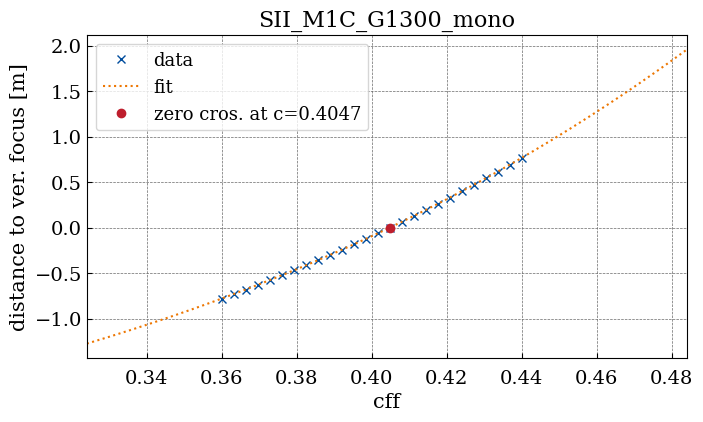

In [164]:
indx = 3
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)

Chaîne SII_M1C_G1300_mono:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out 
>>>>> Beamline configuration:
                   SII        0.0 m,        0.0°
                 pupil     19.776 m,        0.0°
                   M1A        0.5 m,        2.5°
                   M1C    0.71137 m,        2.5°
          grating_1300   5.291337 m,   7.856594°
                    M2   0.073849 m,   7.856594°
              mono_hfs   0.528911 m,        0.0°
              mono_out        2.4 m,        0.0°


------------------ horizontal-plane:
> Beam focusing at     -2.294 ± 0.001 m
------------------ vertical-plane:
> Beam focusing at        0.0 ±   0.0 m


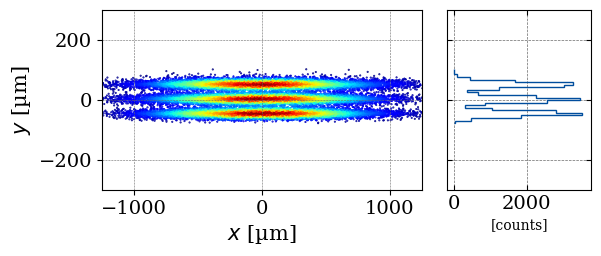

In [165]:
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

Chaîne SII_M1C_G1300_wolter:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out -> M3 -> M4 -> wolter 
>>>>> Beamline configuration:
                   SII        0.0 m,        0.0°
                 pupil     19.776 m,        0.0°
                   M1A        0.5 m,        2.5°
                   M1C    0.71137 m,        2.5°
          grating_1300   5.291337 m,   7.856594°
                    M2   0.073849 m,   7.856594°
              mono_hfs   0.528911 m,        0.0°
              mono_out        2.4 m,        0.0°
                    M3        5.0 m,        2.0°
                    M4        0.4 m,        2.0°
                wolter        2.2 m,        0.0°
------------------ horizontal-plane:
> Beam focusing at      0.018 ±   0.0 m
------------------ vertical-plane:
> Beam focusing at     -0.006 ±   0.0 m

------------------ horizontal-plane:
> Beam focusing at 0.018 m
>> RMS beam size: 12.7 µm (FWHM: 29.4 µm)
>> Divergence: 637.6 µrad (FWHM: 1450.5 µrad)


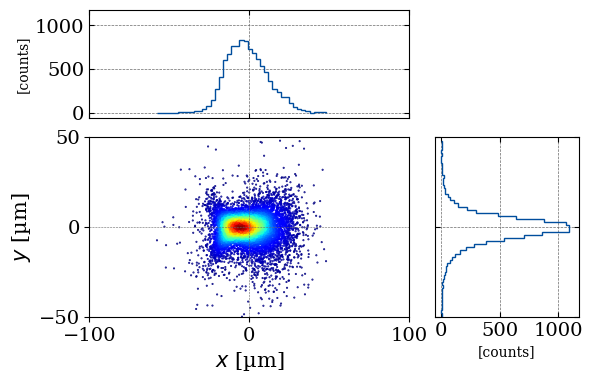

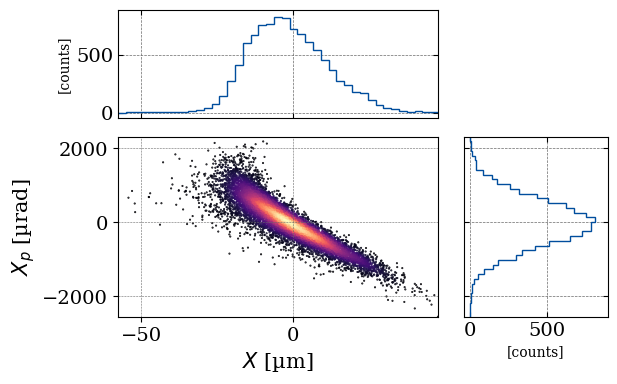

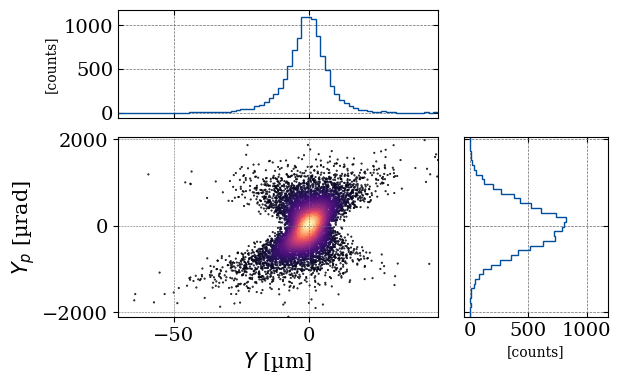

In [166]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

### Cylindrical mirror + C scan

In [167]:
reset_beamline()

m1c.distance_from_previous = m1_distances['M1C']['dist']
m1c.theta = m1_grazing_angles[1]
m1c.phi = 180*degree
m1c.major_curvature = 1/209.6
m1c.minor_curvature = 1/1e23
m1c.recording_mode = opx.RecordingMode.recording_output

indx = 3
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=None, nrept=nrept)

Chaîne SII_M1C_G1300_mono:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out 
>>>>> Beamline configuration:
                   SII        0.0 m,        0.0°
                 pupil     19.776 m,        0.0°
                   M1A        0.5 m,        2.5°
                   M1C    0.71137 m,        2.5°
          grating_1300   5.291337 m,   7.856594°
                    M2   0.073849 m,   7.856594°
              mono_hfs   0.528911 m,        0.0°
              mono_out        2.4 m,        0.0°


------------------ horizontal-plane:
> Beam focusing at      -2.45 ± 0.001 m
------------------ vertical-plane:
> Beam focusing at      0.015 ± 0.001 m


Chaîne SII_M1C_G1300_mono:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out 


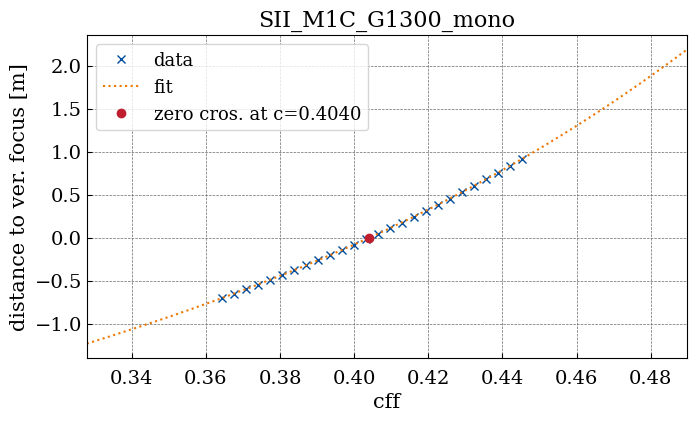

In [168]:
pres_cff_he[indx] = cscan(configs_mono_he[indx], le, nrays, np.linspace(.90, 1.10, 26)*pres_cff_he[indx], True, nrept=nrept)

Chaîne SII_M1C_G1300_mono:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out 
>>>>> Beamline configuration:
                   SII        0.0 m,        0.0°
                 pupil     19.776 m,        0.0°
                   M1A        0.5 m,        2.5°
                   M1C    0.71137 m,        2.5°
          grating_1300   5.291337 m,   7.849913°
                    M2   0.073911 m,   7.849913°
              mono_hfs   0.528847 m,        0.0°
              mono_out        2.4 m,        0.0°


------------------ horizontal-plane:
> Beam focusing at     -2.451 ± 0.001 m
------------------ vertical-plane:
> Beam focusing at        0.0 ±   0.0 m


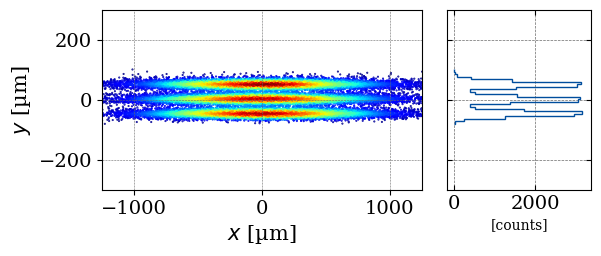

In [169]:
mono_perf(configs_mono_he[indx], le, nrays, pres_cff_he[indx], False, RP=RP, nrept=nrept)

Chaîne SII_M1C_G1300_wolter:
	SII -> pupil -> M1A -> M1C -> grating_1300 -> M2 -> mono_hfs -> mono_out -> M3 -> M4 -> wolter 
>>>>> Beamline configuration:
                   SII        0.0 m,        0.0°
                 pupil     19.776 m,        0.0°
                   M1A        0.5 m,        2.5°
                   M1C    0.71137 m,        2.5°
          grating_1300   5.291337 m,   7.849913°
                    M2   0.073911 m,   7.849913°
              mono_hfs   0.528847 m,        0.0°
              mono_out        2.4 m,        0.0°
                    M3        5.0 m,        2.0°
                    M4        0.4 m,        2.0°
                wolter        2.2 m,        0.0°
------------------ horizontal-plane:
> Beam focusing at       -0.0 ±   0.0 m
------------------ vertical-plane:
> Beam focusing at     -0.006 ±   0.0 m

------------------ horizontal-plane:
> Beam focusing at -0.000 m
>> RMS beam size: 5.8 µm (FWHM: 9.8 µm)
>> Divergence: 671.1 µrad (FWHM: 1470.6 µrad)
>

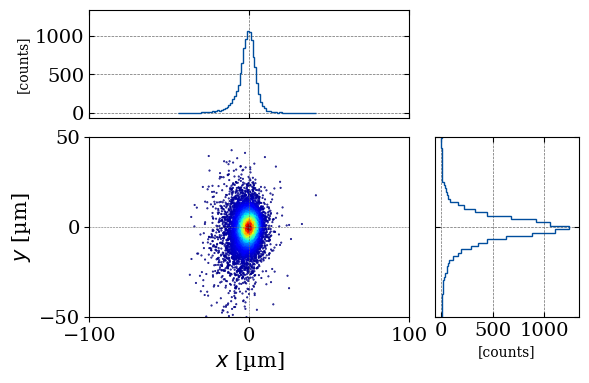

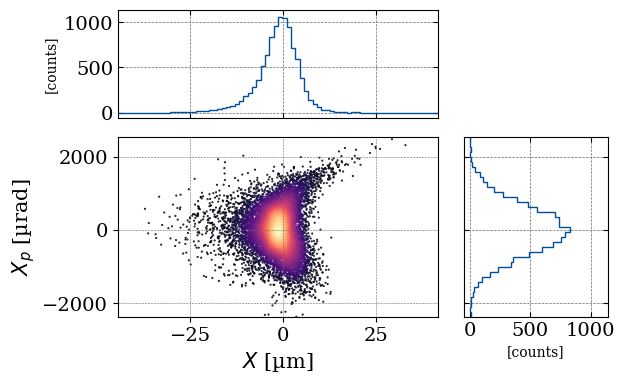

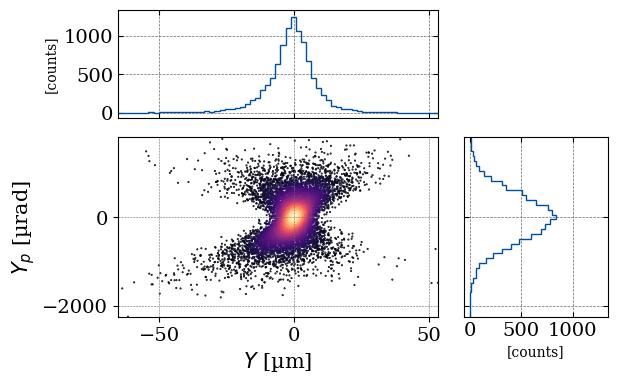

In [170]:
focusing_perf(configs_wt_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-100, 100, -50, 50], nrept=nrept)

In [ ]:
focusing_perf(configs_zp_he[indx], le, nrays, pres_cff_he[indx], True, plot_range=[-175, 175, -75, 75], nrept=nrept)

In [ ]:
reset_beamline()

m1c.distance_from_previous = m1_distances['M1C']['dist']
m1c.theta = m1_grazing_angles[1]
m1c.phi = 180*degree
m1c.major_curvature = 1/214
m1c.minor_curvature = 1/214
m1c.recording_mode = opx.RecordingMode.recording_output